# CNS 2021: Neuropixels Visual Coding Tutorial

## Overview

The Allen Institute has publicly released data from *in vivo* extracellular electrophysiology ("ecephys") experiments in awake mice viewing a variety of visual stimuli. This tutorial will teach you how to access and analyze this data using the AllenSDK, an open-source Python library. It assumes you have basic knowledge of Python and some familiarity with the types of data generated by electrophysiological recordings. 

This tutorial is divided into 5 parts:
* <a href='#Part-1:-Data-access'>Data access</a>
* <a href='#Part-2:-Reading-data-from-an-NWB-file'>Reading data from an NWB file</a>
* <a href='#Part-3:-Aligning-data-to-stimulus-presentations'>Aligning data to stimulus presentations</a>
* <a href='#Part-4:-Receptive-field-mapping'>Receptive field mapping</a>
* <a href='#Part-5:-Decoding-Natural-Images'>Decoding natural images</a>

## Setting up your Python environment

In order to run the code contained in this notebook, we recommend creating a fresh [conda](https://docs.conda.io/en/latest/) environment, e.g.:

```
$ conda create -n allensdk python=3.8
$ conda activate allensdk
```

Then, install the following dependencies using `pip`:

```
(allensdk) $ pip install allensdk
(allensdk) $ pip install scikit-learn
(allensdk) $ pip install notebook ipywidgets
```

Finally, launch a Jupyter notebook from the directory where this notebook is located:

```
(allensdk) $ jupyter notebook
```

# Part 1: Data access

The data from Allen Brain Observatory experiments are organized into *sessions*, where each session is a distinct period of continuous recording. During a Neuropixels session we collect:

- spike times and other spike features (such as mean waveforms) from up to 6 Neuropixels probes inserted simultaneously into a mouse brain
- local field potentials from each probe
- behavioral data, such as running speed and eye position
- the timing and identity of visual stimuli which were presented to the mouse
- cell-type specific optogenetic stimuli applied at the end of the session

The AllenSDK contains code for accessing across-session (project-level) metadata as well as code for accessing detailed within-session data. The standard workflow is to use project-level tools, such as `EcephysProjectCache` to identify and access sessions of interest, then delve into those sessions' data using `EcephysSession`.

If you're running analysis locally, the **`EcephysProjectCache` object of the AllenSDK** is the easiest way to retrieve this data. This object abstracts away the details of on-disk file storage, and delivers the data to you as ready-to-analyze Python objects. The cache will automatically keep track of which files are stored locally, and will download additional files on an as-needed basis.

Alternatively, individual NWB files can be downloaded via the [DANDI Archive](https://gui.dandiarchive.org/#/dandiset/000021), and are also available as part of an [AWS Public Dataset](https://registry.opendata.aws/allen-brain-observatory/) located at `arn:aws:s3:::allen-brain-observatory` in region `us-west-2`.

For a more detailed looked at data access, check out [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_data_access.html).

## Using the AllenSDK to retrieve data

To get started with this approach, first take care of the necessary imports:

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

Before downloading the data, you must decide where the **`manifest.json`** file lives. This file serves as the map that guides the `EcephysProjectCache` object to any files that are stored locally, and uses a network connection to retrieve any files that haven't been downloaded yet.

When you initialize a local cache for the first time, it will create the manifest file at the path that you specify. This file lives in the same directory as the rest of the data, so make sure you put it somewhere that has plenty of space available. If you want to download the complete dataset (58 experiments), you'll need 855 GB of space, split across the following files:

1. CSV files containing information about sessions, probes, channels and units (58.1 MB)
2. NWB files containing spike times, behavior data, and stimulus information for each session (146.5 GB total, min file size = 1.7 GB, max file size = 3.3 GB)
3. NWB files containing LFP data for each probe (707 GB total, min file size = 0.9 GB, max file size = 2.7 GB)

When you need to access the data in subsequent analysis sessions, you should point the `EcephysProjectCache` object to an _existing_ `manifest.json` file; otherwise, it will try to re-download the data in a new location.

In [2]:
data_directory = "/path/to/data/cache" # storage location with plenty of space available

manifest_path = os.path.join(data_directory, "manifest.json")

Now we can create the cache object by pointing it to the `manifest_path`:

In [3]:
cache = EcephysProjectCache(manifest = manifest_path)

This will prepare the cache to download four files:

1. `sessions.csv` (7.8 kB)
2. `probes.csv` (27.0 kB)
3. `channels.csv` (6.6 MB)
4. `units.csv` (51.4 MB)

Each one contains a table of information related to its file name. If you're using the AllenSDK, you won't have to worry about how these files are formatted. Instead, you'll load the relevant data using specific accessor functions: `get_session_table()`, `get_probes()`, `get_channels()`, and `get_units()`. These functions return a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html?highlight=dataframe) containing a row for each item and a column for each metric.

Let's take a closer look at what's in the `sessions.csv` file:

In [4]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


The `sessions` DataFrame provides a high-level overview of the Neuropixels Visual Coding dataset. The index column is a unique ID, which serves as a key for accessing the physiology data for each session. The other columns contain information about:

- the session type (i.e., which stimulus set was shown?)
- the age, sex, and genotype of the mouse (in this dataset, there's only one session per mouse)
- the number of probes, channels, and units for each session
- the brain structures recorded (CCFv3 acronyms)

If we want to find all of recordings from male Sst-Cre mice that viewed the Brain Observatory 1.1 stimulus and contain units from area LM, we can use the following query:

In [5]:
filtered_sessions = sessions[(sessions.sex == 'M') & \
                             (sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISl' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

filtered_sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."


The `filtered_sessions` table contains the three sessions that meet these criteria.

The code above uses standard syntax for filtering pandas DataFrames. If this is unfamiliar to you, we strongly recommend reading through the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/). The AllenSDK makes heavy use of pandas objects, so we don't have to come up with our own functions for working with tabular data.

Let's take a look at another DataFrame, extracted from the `probes.csv` file.

In [6]:
probes = cache.get_probes()

print('Total number of probes: ' + str(len(probes)))

probes.head()

Total number of probes: 332


,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,unit_count,channel_count,ecephys_structure_acronyms
id,,,,,,,,,
729445648,719161530,1249.998642,probeA,3a,29999.967418,True,87,374,"[APN, LP, MB, DG, CA1, VISam, nan]"
729445650,719161530,1249.996620,probeB,3a,29999.918880,True,202,368,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan]"
729445652,719161530,1249.999897,probeC,3a,29999.997521,True,207,373,"[APN, NOT, MB, DG, SUB, VISp, nan]"
729445654,719161530,1249.996707,probeD,3a,29999.920963,True,93,358,"[grey, VL, CA3, CA2, CA1, VISl, nan]"
729445656,719161530,1249.999979,probeE,3a,29999.999500,True,138,370,"[PO, VPM, TH, LP, LGd, CA3, DG, CA1, VISal, nan]"


The `probes` DataFrame contains information about the Neuropixels probes used across all recordings. Each row represents one probe from one recording session, even though the physical probes may have been used in multiple sessions. Some of the important columns are:

- `ecephys_session_id`: the index column of the `sessions` table
- `sampling_rate`: the sampling rate (in Hz) for this probe's spike band; note that each probe has a unique sampling rate around 30 kHz. The small variations in sampling rate across probes can add up to large offsets over time, so it's critical to take these differences into account. However, all of the data you will interact with has been pre-aligned to a common clock, so this value is included only for reference purposes.
- `lfp_sampling_rate`: the sampling rate (in Hz) for this probe's LFP band NWB files, after 2x downsampling from the original rate of 2.5 kHz
- `name`: the probe name is assigned based on the location of the probe on the recording rig. This is useful to keep in mind because probes with the same name are always targeted to the same cortical region and enter the brain from the same angle (`probeA` = AM, `probeB` = PM, `probeC` = V1, `probeD` = LM, `probeE` = AL, `probeF` = RL). However, the targeting is not always accurate, so the actual recorded region may be different.
- `phase`: the data may have been generated by one of two "phases" of Neuropixels probes. **3a** = prototype version; **PXI** = publicly available version ("Neuropixels 1.0"). The two phases should be equivalent from the perspective of data analysis, but there may be differences in the noise characteristics between the two acquisition systems.
- `channel_count`: the number of channels with spikes or LFP data (maximum = 384)

The `channels.csv` file contains information about each of these channels.

In [7]:
channels = cache.get_channels()

print('Total number of channels: ' + str(len(channels)))

channels.head()

Total number of channels: 123224


,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
849705558,792645504,1,11,20,8165.0,3314.0,6862.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705560,792645504,2,59,40,8162.0,3307.0,6866.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705562,792645504,3,27,40,8160.0,3301.0,6871.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705564,792645504,4,43,60,8157.0,3295.0,6875.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705566,792645504,5,11,60,8155.0,3288.0,6879.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0


The most important columns in the `channels` DataFrame concern each channel's location in physical space. Each channel is associated with a location along the probe shank (`probe_horizontal_position` and `probe_vertical_position`), and may be linked to a coordinate in the Allen Common Coordinate framework (if CCF registration is available for that probe).

The information about channel location will be merged into the `units` DataFrame, which is loaded from `units.csv`:

In [8]:
units = cache.get_units()

print('Total number of units: ' + str(len(units)))

Total number of units: 40010


This DataFrame contains metadata about the available units across all sessions. By default, the AllenSDK applies some filters to this table and only returns units above a particular quality threshold.

The default filter values are as follows:

- `isi_violations` < 0.5
- `amplitude_cutoff` < 0.1
- `presence_ratio` > 0.95

For more information about these quality metrics and how to interpret them, please refer to [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html).

If you want to see _all_ of the available units, it's straightfoward to disable the quality metrics filters when retrieving this table: 

In [9]:
units = cache.get_units(amplitude_cutoff_maximum = np.inf,
                        presence_ratio_minimum = -np.inf,
                        isi_violations_maximum = np.inf)

print('Total number of units: ' + str(len(units)))

Total number of units: 99180


As you can see, the number of units has increased substantially, but some fraction of these units will be incomplete or highly contaminated. Understanding the meaning of these metrics is a critical part of analyzing the Neuropixels dataset, so we strongly recommend learning how to interpret them correctly.

Let's look at the location of all of these units within the CCF, to get a sense of the areas that this dataset covers:

Text(7000, -3200, 'thalamus')

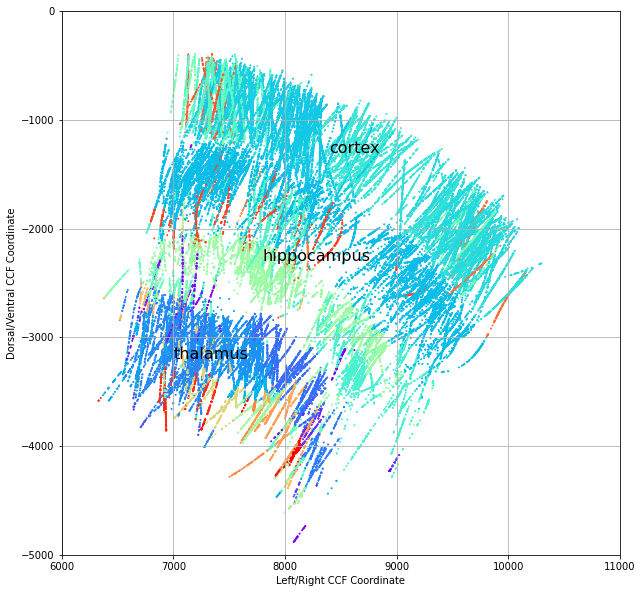

In [10]:
structure_ids = units.ecephys_structure_id
valid_structure_ids = np.invert(np.isnan(structure_ids))
all_structure_ids, labels = np.unique(units.ecephys_structure_id[valid_structure_ids], return_inverse=True)
lr_coords = units.left_right_ccf_coordinate[valid_structure_ids]
dv_coords = units.dorsal_ventral_ccf_coordinate[valid_structure_ids]

plt.figure(figsize=(10,10))
plt.scatter(lr_coords, -dv_coords, s=1, c=labels, cmap='rainbow')
plt.xlim([6000,11000])
plt.ylim([-5000,0])
plt.xlabel('Left/Right CCF Coordinate')
plt.ylabel('Dorsal/Ventral CCF Coordinate')
plt.grid('on')

plt.text(8400,-1300, 'cortex', fontsize=16)
plt.text(7800,-2300, 'hippocampus', fontsize=16)
plt.text(7000,-3200, 'thalamus', fontsize=16)

The above plot shows the location of all units that have been registered to the CCF, viewed in a coronal section looking from the front of the brain. You can see stripes for the cortex, hippocampus, and thalamus.

# Part 2: Reading data from an NWB file

We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. Calling `get_session_data` on your `EcephysProjectCache` will download such a file and return an `EcephysSession` object.

`EcephysSession` objects contain methods and properties that access the data within an ecephys NWB file and cache it in memory.

Let's look at a file from one of the sessions we selected earlier. If you're accessing the data on your local machine, it may take some time to download the full dataset (approximately 2.6 GB):

In [11]:
session_id = filtered_sessions.index.values[2]

session = cache.get_session_data(session_id)

## Reading in spike times

First, we'll learn how to explore the available units in this dataset, and look at their spike times and waveforms. 

Information about the recorded units is available in the `session.units` DataFrame:

In [12]:
units = session.units

print('Total number of units: ' + str(len(units)))

units.head()

Total number of units: 684


,L_ratio,presence_ratio,d_prime,waveform_halfwidth,cluster_id,firing_rate,peak_channel_id,silhouette_score,waveform_repolarization_slope,waveform_amplitude,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951814884,0.024771,0.99,3.555518,0.096147,6,9.492176,850126382,0.033776,0.673650,187.434780,...,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814876,0.001785,0.99,4.445414,0.206030,5,39.100557,850126382,0.108908,0.518633,129.686505,...,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815032,0.035654,0.99,3.848256,0.096147,17,28.383277,850126398,0.096715,0.766347,207.380940,...,215.0,APN,8129.0,3419.0,6762.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815275,0.016783,0.99,3.065938,0.096147,30,5.709358,850126416,0.144249,0.628944,158.158650,...,215.0,APN,8095.0,3349.0,6787.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815314,0.009666,0.99,4.198612,0.123618,34,23.902235,850126420,0.111106,0.740222,173.475705,...,215.0,APN,8088.0,3333.0,6792.0,probeA,See electrode locations,29999.949611,1249.9979,True


This table contains a variety of helpful metrics for each unit, such as its firing rate, waveform_amplitude, and CCF structure (`ecephys_structure_acronym`). There are also sorting quality metrics, such as `isi_violations`, `amplitude_cutoff`, and `presence_ratio`. Let's begin by selecting all the units in V1 (`VISp`) that have a low ISI violations score (an indication of low contamination levels):

In [13]:
V1_units = units[(units.ecephys_structure_acronym == 'VISp') &
                (units.isi_violations < 0.1)]

print('Total number of low-contamination V1 units: ' + str(len(V1_units)))

Total number of low-contamination V1 units: 35


We will use the index column of this table (labeled `unit_id`) to extract the data for individual units, such as their spike times and waveforms. 

To retrieve the spike times for one unit as a `numpy` array, simply call `session.spike_times[unit_id]`:

In [14]:
unit_id = V1_units.index.values[0]

session.spike_times[unit_id]

/Users/Josh/opt/miniconda3/envs/allensdk-latest/lib/python3.8/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


array([4.38972776e+00, 4.95332954e+00, 5.66793179e+00, ...,
       9.96473648e+03, 9.96522671e+03, 9.96535038e+03])

Depending on the session you're analyzing, you may see a warning about invalid time intervals. The default session (`756029989`) does have some invalid times, which can result from interruptions in data acquisition or problems with the stimulus display. We've chosen to release sessions with some invalid intervals, in order to avoid throwing away valuable data. To see the intervals (and reasons for invalidation), just type `session.invalid_times`:

In [15]:
session.invalid_times

,start_time,stop_time,tags
id,,,
0,7675.15,7692.68,"[EcephysProbe, 760640097, probeE]"


Here, we see that Probe E is missing data between 7675 and 7692 seconds. If you're analyzing this section of the data, this will explain why there's a gap during this interval, which is not due to the fact that all units suddenly became silent on this probe.

## Reading in unit waveforms

We store precomputed mean waveforms for each unit in the `mean_waveforms` attribute on the `EcephysSession` object. This is a dictionary which maps unit ids to xarray [DataArrays](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html). These have `channel` and `time` (seconds, aligned to the detected event times) dimensions. The data values are in microvolts, as measured at the recording site.

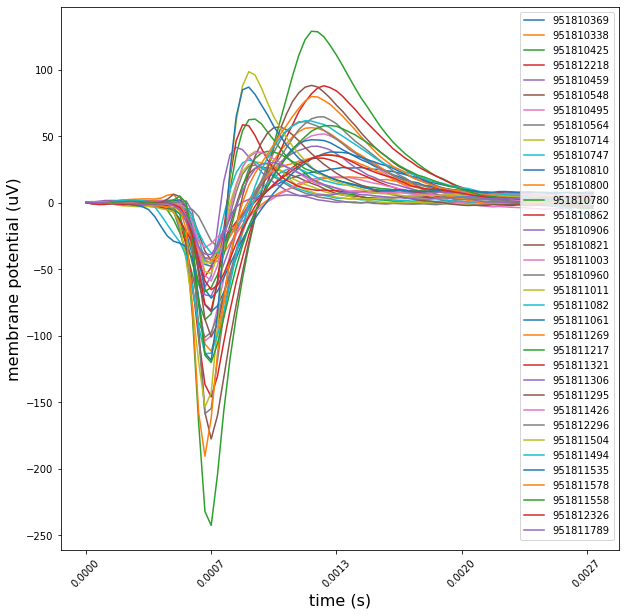

In [16]:
units_of_interest = V1_units.index.values

waveforms = {uid: session.mean_waveforms[uid] for uid in units_of_interest}
peak_channels = {uid: session.units.loc[uid, 'peak_channel_id'] for uid in units_of_interest}

# plot the mean waveform on each unit's peak channel/
plot_mean_waveforms(waveforms, units_of_interest, peak_channels)
plt.show()

This plot only includes the peak channel waveform for each unit, but the NWB file contains the waveform across the entire probe, allowing you to analyze how it propagates along the probe axis.

## Stimulus presentation times

Next, we'll look at how to access information about the visual stimuli that were presented.

`session.stimulus_names` will show the stimuli that are available in this session:

In [17]:
session.stimulus_names

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

Access the stimulus table for a particular stimulus type can be done with the following line of code:

In [18]:
stim_table = session.get_stimulus_table(['drifting_gratings'])

stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1585.734418,2,drifting_gratings,1587.736098,2,2.00168,246
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1588.736891,2,drifting_gratings,1590.738571,2,2.00168,247
3800,0.8,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1591.739398,2,drifting_gratings,1593.741078,2,2.00168,246
3801,0.8,270,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1594.741921,2,drifting_gratings,1596.743591,2,2.00167,248
3802,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1597.744458,2,drifting_gratings,1599.746088,4,2.00163,249


This shows us the parameters for each stimulus presentation (trial), indexed by a unique stimulus presentation ID.

## Behavioral data

We can obtain the mouse's running speed at each point during the experiment by using the `running_speed` attribute of the `session` object. This returns a pandas `DataFrame` whose rows are intervals of time (defined by `start_time` and `end_time` columns), and whose `velocity` column contains mean running speeds within those intervals.

Here we'll plot the running speed trace for an arbitrary chunk of time.

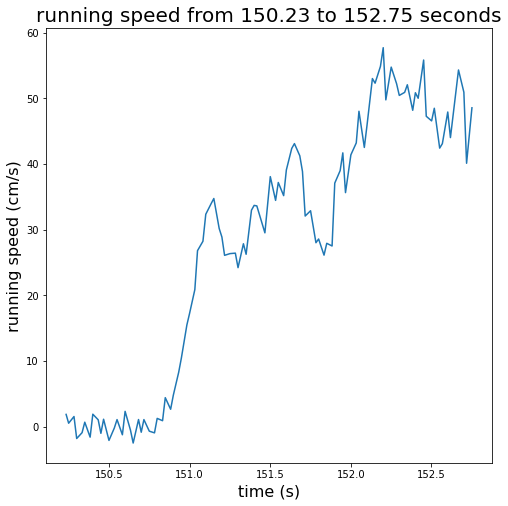

In [19]:
plot_running_speed(
    session.running_speed["start_time"], 
    session.running_speed["velocity"], 
    start_index=5000,
    stop_index=5100
)

plt.show()

To obtain information about where the animal was looking on the screen, we can call `session.get_screen_gaze_data()`

In [20]:
gaze_data = session.get_screen_gaze_data()
gaze_data.head()

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.20620,0.072246,0.008627,3.192181,0.863288,11.996034,3.294251
3.22948,0.072116,0.008734,3.103325,0.916339,11.669031,3.496204
3.23714,0.072292,0.008807,3.116553,0.919020,11.717276,3.506406
3.27028,0.072347,0.008060,3.107700,1.061316,11.677819,4.047634
3.30396,0.072026,0.008814,3.285226,0.929605,12.331983,3.546691


This table also contains information about the pupil area, which we can plot over time:

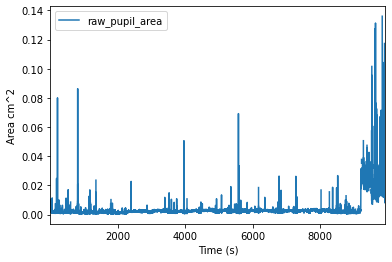

In [21]:
ax = gaze_data[["raw_pupil_area"]].plot()
_ = ax.set_ylabel("Area cm^2")

## Part 3: Aligning data to stimulus presentations

Reading in the data is an essential first step, but most analyses require some form of stimulus alignment. This part of the tutorial will show you how to do that!

First we need to select some trials to use. Let's use full-field flashes (gray-to-black or gray-to-white):

In [22]:
presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'flashes']

presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values

### Aligning spike times

The AllenSDK includes some convenient functions for aligning spikes; if you just want to see all the spike times that fall between the start and end of a set of trials, you can call `session.presentationwise_spike_times`. This takes a list of stimulus presentation IDs and unit IDs, and returns a DataFrame:

In [23]:
times = session.presentationwise_spike_times(
    stimulus_presentation_ids=presentation_ids,
    unit_ids=units_of_interest
)

times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1285.489506,3647,951811082,0.006108
1285.495473,3647,951812218,0.012075
1285.496440,3647,951810714,0.013042
1285.498573,3647,951811011,0.015175
1285.514240,3647,951810714,0.030842


The `times` DataFrame contains columns for the stimulus presentation ID and unit ID, as well as the `time_since_stimulus_presentation_onset`, which is the spike time shifted to account for the trial start time.

Using this DataFrame as input, we can make a raster plot for one trial:

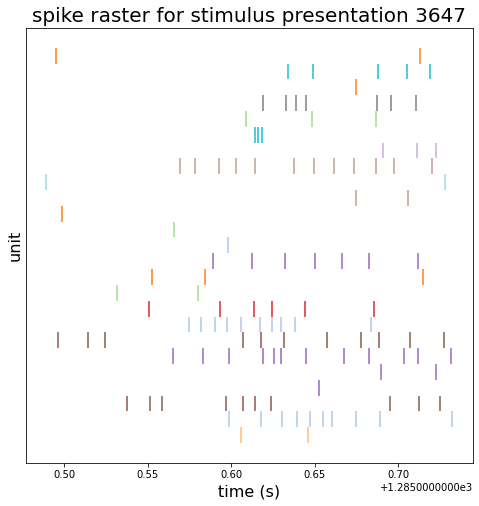

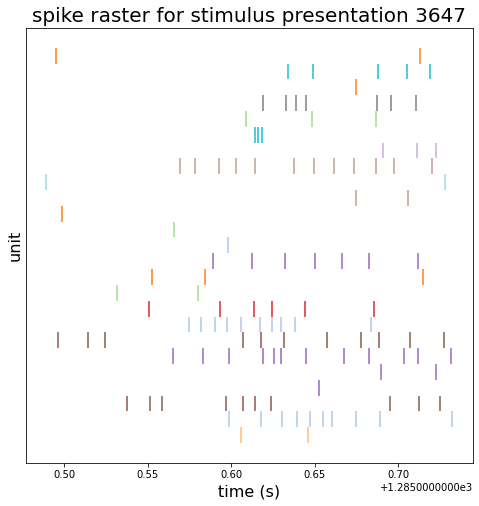

In [24]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

raster_plot(plot_times,
            title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')

### Binning spike times

Instead of returning the individual spike times, we can also use the AllenSDK to bin spike times within a pre-defined interval. This is done by calling the `session.presentationwise_spike_counts` method. Similarly to `session.presentationwise_spike_times`, this method takes stimulus presentation IDs and unit IDs as input. But it also requires one additional argument, which is the edges of the time bins (relative to the start of each trial) for which we want to count spikesL

In [25]:
# First, specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 200)

spike_counts = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=presentation_ids,
    unit_ids=units_of_interest
)

spike_counts

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 199, unit_id: 35)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951810369 ... 951811789

This has returned an `xarray.DataArray` with the following helpful features:

- Dimensions : Each axis on each data variable is associated with a named dimension. This lets us see unambiguously what the axes of our array mean.
- Coordinates : Arrays of labels for each sample on each dimension.

xarray is nice because it forces code to be explicit about dimensions and coordinates, improving readability and avoiding bugs. However, you can always convert to numpy or pandas data structures as follows:
- to pandas: `spike_counts_ds.to_dataframe()` produces a multiindexed dataframe
- to numpy: `spike_counts_ds.values` gives you access to the underlying numpy array

We can now plot spike counts for a particular presentation:

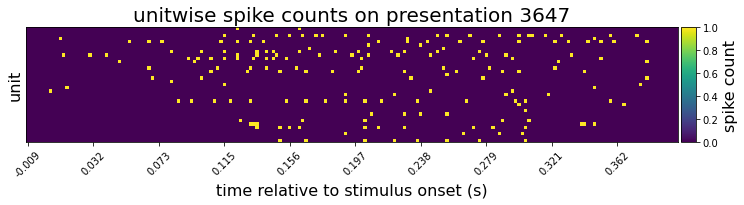

In [26]:
presentation_id = presentation_ids[0] # chosen arbitrarily
plot_spike_counts(
    spike_counts.loc[{'stimulus_presentation_id': presentation_id}], 
    spike_counts['time_relative_to_stimulus_onset'],
    'spike count', 
    f'unitwise spike counts on presentation {presentation_id}'
)
plt.show()

We can also average across all presentations, adding a new data array to the dataset. Notice that this one no longer has a `stimulus_presentation_id` dimension, as we have collapsed it by averaging.

In [27]:
mean_spike_counts = spike_counts.mean(dim='stimulus_presentation_id')

mean_spike_counts

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 199, unit_id: 35)>
array([[0.        , 0.00666667, 0.        , ..., 0.        , 0.        ,
        0.00666667],
       [0.01333333, 0.        , 0.00666667, ..., 0.00666667, 0.        ,
        0.        ],
       [0.00666667, 0.00666667, 0.01333333, ..., 0.01333333, 0.        ,
        0.02666667],
       ...,
       [0.00666667, 0.        , 0.01333333, ..., 0.        , 0.        ,
        0.00666667],
       [0.01333333, 0.        , 0.04      , ..., 0.        , 0.        ,
        0.00666667],
       [0.01333333, 0.        , 0.04      , ..., 0.        , 0.        ,
        0.01333333]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951810369 ... 951811789

... and plot the mean spike counts:

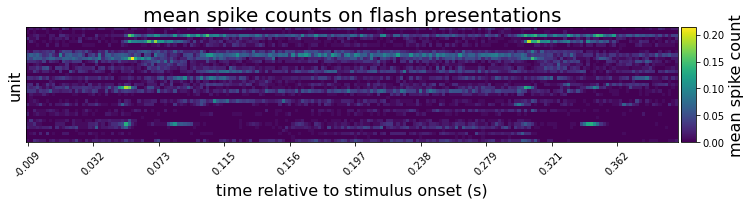

In [28]:
plot_spike_counts(
    mean_spike_counts, 
    mean_spike_counts['time_relative_to_stimulus_onset'],
    'mean spike count', 
    'mean spike counts on flash presentations'
)
plt.show()

## Part 4: Receptive field mapping

Because receptive field analysis is so central to interpreting results related from the visual system, every experiment in the Neuropixels Visual Coding dataset includes a standardized receptive field mapping stimulus. This stimulus is always shown at the beginning of the session, and uses the same parameters for every mouse. 

We can look at the `stimulus_presentations` DataFrame in order to examine the parameters of the receptive field mapping stimulus in more detail. The receptive field mapping stimulus consists of drifting Gabor patches with a circular mask, so we're going to filter the DataFrame based on `stimulus_name == 'gabors'`:

In [29]:
rf_stim_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'gabors']

len(rf_stim_table)

3645

There are 3645 trials for the receptive field mapping stimulus. What combination of stimulus parameters is used across these trials? Let's see which parameters actually vary for this stimulus:

In [30]:
keys = rf_stim_table.keys()
[key for key in keys if len(np.unique(rf_stim_table[key])) > 1]

['orientation',
 'start_time',
 'stop_time',
 'x_position',
 'y_position',
 'duration',
 'stimulus_condition_id']

We can ignore the parameters related to stimulus timing (`start_time`, `stop_time`, and `duration`), as well as `stimulus_condition_id`, which is used to find presentations with the same parameters. So we're left with `orientation`, `x_position`, and `y_position`.

In [31]:
print('Unique orientations : ' + str(list(np.sort(rf_stim_table.orientation.unique()))))
print('Unique x positions : ' + str(list(np.sort(rf_stim_table.x_position.unique()))))
print('Unique y positions : ' + str(list(np.sort(rf_stim_table.y_position.unique()))))

Unique orientations : [0.0, 45.0, 90.0]
Unique x positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]
Unique y positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]


What about the drifting grating parameters that don't vary, such as size (in degrees), spatial frequency (in cycles/degree), temporal frequency (in Hz), and contrast?

In [32]:
print('Spatial frequency: ' + str(rf_stim_table.spatial_frequency.unique()[0]))
print('Temporal frequency: ' + str(rf_stim_table.temporal_frequency.unique()[0]))
print('Size: ' + str(rf_stim_table['size'].unique()[0]))
print('Contrast: ' + str(rf_stim_table['contrast'].unique()[0]))

Spatial frequency: 0.08
Temporal frequency: 4.0
Size: [20.0, 20.0]
Contrast: 0.8


In order to visualize receptive fields, we're going to use a function in the `ReceptiveFieldMapping` class, one of the stimulus-specific analysis classes in the AllenSDK. Let's import it and create a `rf_mapping` object based on the `session` we loaded earlier:

In [33]:
from allensdk.brain_observatory.ecephys.stimulus_analysis.receptive_field_mapping import ReceptiveFieldMapping

rf_mapping = ReceptiveFieldMapping(session)

Let's use the same V1 units we extracted previously.

Calculating the receptive field is as simple as calling `get_receptive_field()` with a unit ID as the input argument.

In [34]:
RF = rf_mapping.get_receptive_field(V1_units.index.values[3])

/Users/Josh/opt/miniconda3/envs/allensdk-latest/lib/python3.8/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:644: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(0, 1)], with a maximum overlap of 0.015484041324228315 seconds.
  warnings.warn(f"You've specified some overlapping time intervals between neighboring rows: {overlapping}, "


This method creates a 2D histogram of spike counts at all 81 possible stimulus locations, and outputs it as a 9 x 9 matrix. It's summing over all orientations, so each pixel contains the spike count across 45 trials.
 
To plot it, just display it as an image. The matrix is already in the correct orientation so that it matches the layout of the screen (e.g., the upper right pixel contains the spike count when the Gabor patch was in the upper right of the screen).

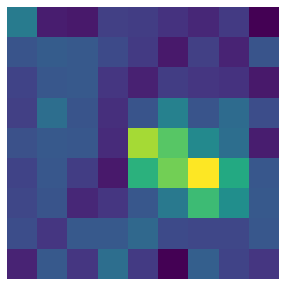

In [35]:
plt.figure(figsize=(5,5))
_ = plt.imshow(RF)
_ = plt.axis('off')

This particular unit has a receptive field that's near the center of the screen, but shifted slightly to the lower right.

Let's plot the receptive fields for the units in V1 we selected previously:

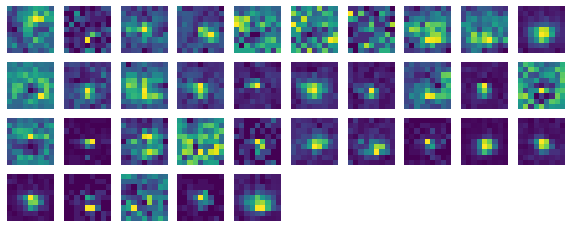

In [36]:
def plot_rf(unit_id, index):
    RF = rf_mapping.get_receptive_field(unit_id)
    _ = plt.subplot(6,10,index+1)
    _ = plt.imshow(RF)
    _ = plt.axis('off')
    
_ = plt.figure(figsize=(10,6))
_ = [plot_rf(RF, index) for index, RF in enumerate(V1_units.index.values)]

It's important to look at the receptive fields for any the visual cortex units you're analyzing, especially if you're looking at interactions between units in different areas. The strength cross-area interactions will vary depending on the degree of receptive field overlap of the recording sites.

## Part 5: Decoding Natural Images

In the last part of this tutorial, we'll use the data to answer an interesting scientific question: can we use activity in primary visual cortex to decode the identity of the image the mouse is currently viewing?

To do this, we'll first extract the stimulus table for the `natural_scenes` presentations:

In [37]:
scene_presentations = session.get_stimulus_table("natural_scenes")

scene_presentations

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51355,95,5909.365398,9,natural_scenes,5909.615606,0.250208,4908
51356,87,5909.615606,9,natural_scenes,5909.865814,0.250208,4909
51357,72,5909.865814,9,natural_scenes,5910.116023,0.250208,4910
51358,41,5910.116023,9,natural_scenes,5910.366231,0.250208,4911
51359,9,5910.366231,9,natural_scenes,5910.616443,0.250212,4912
...,...,...,...,...,...,...,...
68224,81,8567.837656,13,natural_scenes,8568.087864,0.250208,4927
68225,17,8568.087864,13,natural_scenes,8568.338073,0.250208,5011
68226,113,8568.338073,13,natural_scenes,8568.588281,0.250208,4944


Then, we can align the units in V1 to those presentation times, using the `presentationwise_spike_times` method we learned about earlier:

In [38]:
visp_units = session.units[session.units["ecephys_structure_acronym"] == "VISp"]

spikes = session.presentationwise_spike_times(
    stimulus_presentation_ids=scene_presentations.index.values,
    unit_ids=visp_units.index.values[:]
)

spikes

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5909.367606,51355,951810564,0.002208
5909.375006,51355,951810780,0.009608
5909.376406,51355,951811227,0.011008
5909.377206,51355,951810459,0.011808
5909.378406,51355,951811321,0.013008
...,...,...,...
8569.076638,68228,951810906,0.238150
8569.079838,68228,951810392,0.241350
8569.080138,68228,951810800,0.241650


The input to our classification algorithm will be an *N* presentations x *M* units matrix containing the total number of spikes for each presentation/unit combination.

We can create this using the pandas `groupby` and `pivot_table` methods:

In [39]:
spikes["count"] = np.zeros(spikes.shape[0])
spikes = spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

design = pd.pivot_table(
    spikes, 
    values="count", 
    index="stimulus_presentation_id", 
    columns="unit_id", 
    fill_value=0.0,
    aggfunc=np.sum
)

design

unit_id,951810314,951810338,951810369,951810392,951810425,951810459,951810495,951810517,951810548,951810564,...,951811546,951811558,951811578,951811646,951811778,951811789,951812218,951812284,951812296,951812326
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,
51355,0,4,1,1,13,9,10,5,3,30,...,0,0,0,0,2,14,7,1,1,0
51356,0,5,1,2,14,7,12,3,1,22,...,0,1,0,1,1,13,6,0,0,1
51357,0,2,2,0,8,2,11,0,2,8,...,0,1,0,1,1,10,10,1,0,0
51358,1,3,2,1,1,5,1,0,0,10,...,1,0,2,0,1,9,4,0,0,0
51359,0,8,5,0,2,3,2,0,2,9,...,0,0,0,0,2,13,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,1,6,0,1,8,4,0,0,0,5,...,0,0,0,0,4,2,0,0,0,0
68225,1,5,0,1,9,2,1,0,0,18,...,2,0,5,1,4,4,0,1,0,0
68226,0,1,1,1,7,5,3,0,3,9,...,0,0,0,1,1,0,1,0,0,1


...and the target values we want the classifier to learn will be the numeric identifiers of the images that were presented on each trial:

In [40]:
targets = scene_presentations.loc[design.index.values, "frame"]
targets

stimulus_presentation_id
51355     95
51356     87
51357     72
51358     41
51359      9
        ... 
68224     81
68225     17
68226    113
68227     59
68228     98
Name: frame, Length: 5950, dtype: object

We'll use scikit-learn to do the prediction:

In [41]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

The following code trains a support vector machine to classify images based on a subset of the spike counts. It does this 5 times (using a different randomized subset of the data):

In [42]:
design_arr = design.values.astype(float)
targets_arr = targets.values.astype(int)

labels = np.unique(targets_arr)

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5).split(design_arr):
    
    clf = svm.SVC(gamma="scale", kernel="rbf")
    clf.fit(design_arr[train_indices], targets_arr[train_indices])
    
    test_targets = targets_arr[test_indices]
    test_predictions = clf.predict(design_arr[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(f"accuracy: {accuracy}")
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=labels))
    
print(" ")
print(f"mean accuracy: {np.mean(accuracy)}")
print(f"chance: {1/labels.size}")

accuracy: 0.36722689075630255
accuracy: 0.35462184873949576
accuracy: 0.3890756302521008
accuracy: 0.4403361344537815
accuracy: 0.23697478991596643
 
mean accuracy: 0.23697478991596643
chance: 0.008403361344537815


The mean accuracy represents the probability that the classifier is able to predict the correct image. Given that there are 119 images to choose from (chance = 0.008), the performance is impressive!

We can now plot the average confusion matrix, which shows the likelihood that the classifier will predict the presence of any of the 119 possible images, given the actual image:

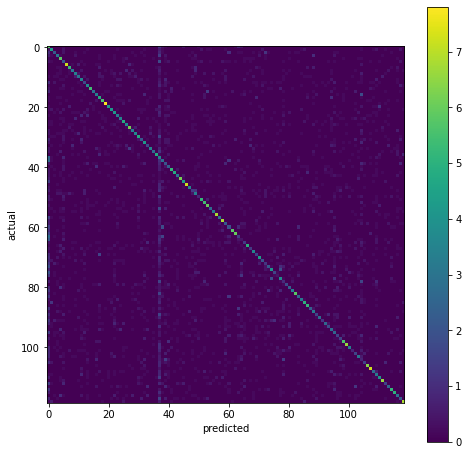

In [43]:
mean_confusion = np.mean(confusions, axis=0)

fig, ax = plt.subplots(figsize=(8, 8))

img = ax.imshow(mean_confusion)
fig.colorbar(img)

ax.set_ylabel("actual")
ax.set_xlabel("predicted")

plt.show()

From this, we can see that some images are more readily decodable than others. Let's take a look at the most decodable and least decodable images:

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

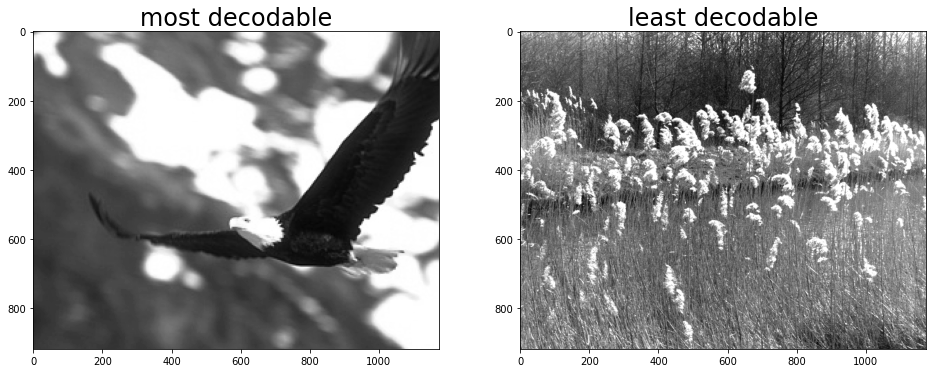

In [44]:
best = labels[np.argmax(np.diag(mean_confusion))]
worst = labels[np.argmin(np.diag(mean_confusion))]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

best_image = cache.get_natural_scene_template(best)
ax[0].imshow(best_image, cmap=plt.cm.gray)
ax[0].set_title("most decodable", fontsize=24)

worst_image = cache.get_natural_scene_template(worst)
ax[1].imshow(worst_image, cmap=plt.cm.gray)
ax[1].set_title("least decodable", fontsize=24)

plt.show()

## Conclusion

Congratulations on finishing this tutorial! For additional tutorials and documentation, we recommend reading through the [AllenSDK ReadTheDocs site](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html). 

It may also be helpful to look at the publication [describing the Neuropixels dataset](https://www.nature.com/articles/s41586-020-03171-x) or the preprint [comparing it to the 2P imaging dataset](https://www.biorxiv.org/content/10.1101/2020.08.10.244723v1). This will give you a taste of the type of analysis that's been done with this dataset so far, which  barely scratches the surface of what's possible. This data was made to be shared, and we're incredibly excited to see what others do with it!